>## Use __tfjs__ env 

>**env:**
>1. install python 3.6.8 ``conda create -n ENVNAME python=3.6.8``
>2. ``pip install tensorflowjs``
>3. ``conda install notebook`` (conda manage dependencies more effectively than ``pip``)

In [1]:
import os 
import numpy as np 
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

## Check if GPU is working 

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
try:
    shutil.rmtree("dataset/data-splited")
    os.remove("save-model.h5")
    os.remove("model.h5")
except:
    print("OK")

OK


In [4]:
import splitfolders
# Splits the dataset
splitfolders.ratio("dataset/data", output="dataset/data-splited", seed=42, ratio=(.7, .15, .15))

In [5]:
from keras.preprocessing.image import ImageDataGenerator

dir_path = "dataset/data-splited"


# Define data augmentation settings
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode="constant",
                                    cval=0, #  This will fill the new pixels with black
                                )

train_set = train_datagen.flow_from_directory(
                                            os.path.join(dir_path, "train"),
                                            shuffle=True,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode="sparse",
                                            )

# validation and test set
datagen = ImageDataGenerator(rescale=1./255)

val_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "val"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=64,
                                    class_mode="sparse",
                                    )

test_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=64,
                                    class_mode="sparse",
                                    )


Found 61 images belonging to 4 classes.
Found 13 images belonging to 4 classes.
Found 17 images belonging to 4 classes.


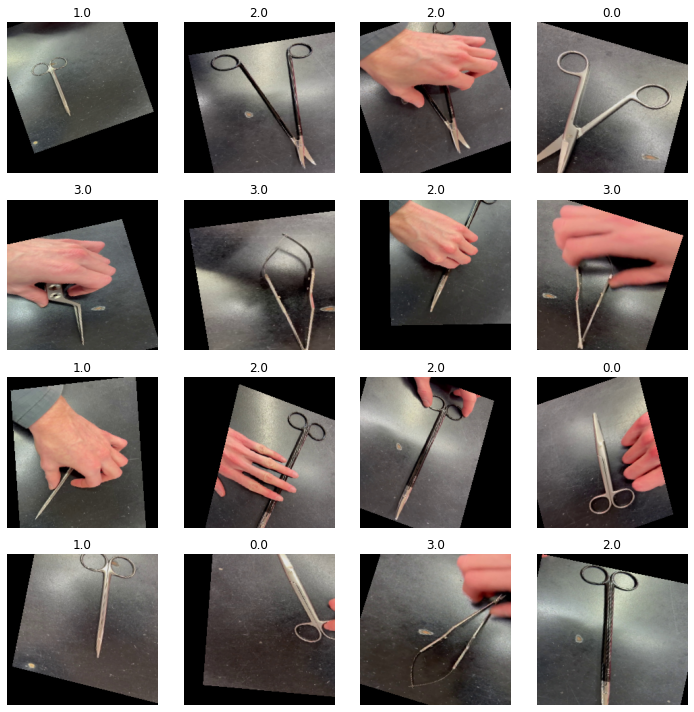

In [6]:
# Extract a batch of images and labels from train_set
images, labels = next(train_set)


# Plotting the first 25 images from the batch

img_train, label_train = next(train_set)

fig, axs =  plt.subplots(4,4, figsize=(10,10))

for i, ax in zip(range(16), axs.ravel()):
    ax.imshow(img_train[i])
    ax.axis('off')
    ax.set_title(label_train[i])
plt.tight_layout()
plt.show()

Mean proportion of images in train set: 15
Mean proportion of images in validation set: 3
Mean proportion of images in test set: 4


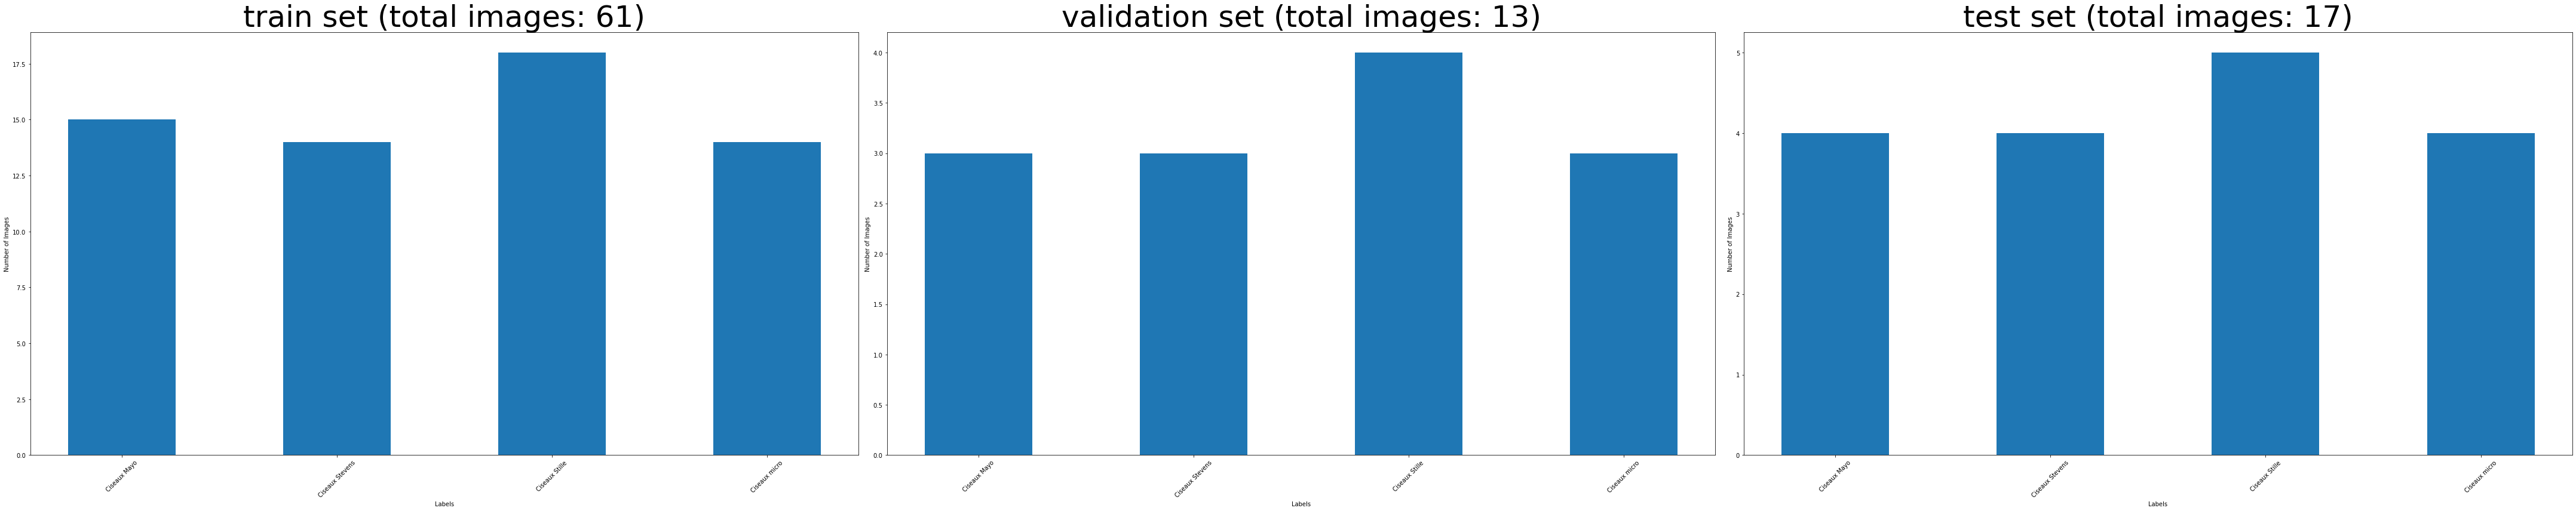

In [7]:
# Setup set names
set_names = ["train set", "validation set", "test set"]
categories = train_set.class_indices.keys()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(60, 12))

for set_name, name, ax in zip(set_names, [train_set, val_set, test_set], axes.ravel()):

    # Get the count of each label in the train set
    proportion = pd.value_counts(name.classes, normalize=False, sort=False)
    print("Mean proportion of images in {}: {:.0f}".format(set_name, proportion.mean()))
    
    ax.bar(categories, proportion, width=0.5)
    ax.set_title(f"{set_name} (total images: {len(name.classes)})", fontsize=50)
    ax.set(
        xlabel="Labels",
        ylabel="Number of Images",
    )
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

In [8]:
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV3Large


# Load the pretrained model
base_model =  MobileNetV3Large(input_shape=(224, 224, 3), weights="imagenet", include_top=False, include_preprocessing=False)

# Make layers of the base model trainable
base_model.trainable = False

# Get the number of layers for the base_model
print(f"The base_model has {len(base_model.layers)} layers.")

# Unfreeze the last few layers for fine-tuning
""" fine_tune_at = 255 """

# Freezes the weights of the pre-train model
""" for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True """


# Creat a new classification layers on top
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
""" x = keras.layers.Dropout(0.2)(x) """
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(train_set.num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])

# Print network summary
model.summary()

The base_model has 268 layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 112, 112, 16) 0           Conv/BatchNorm[0][0]             
_______________________________________________________________

In [9]:
### Code to train the model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# End trainging whe accuracy stops improving
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Reduce learning rate if val_loss doesn't improve
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1,
                              patience=3, min_lr=1e-10)

# Define model checkpoint
checkpoint = ModelCheckpoint("save-model.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

# Fit model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=200,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1,
    workers=1, # Number of workers Depend on your configuration
)

Epoch 1/200
1/1 [==============================] - 14s 14s/step - loss: 1.4325 - acc: 0.1639 - val_loss: 1.3213 - val_acc: 0.3077

Epoch 00001: val_loss improved from inf to 1.32128, saving model to save-model.h5


c:\Users\louis\anaconda3\envs\tfjs\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 1.2666 - acc: 0.2951 - val_loss: 1.1314 - val_acc: 0.5385

Epoch 00002: val_loss improved from 1.32128 to 1.13140, saving model to save-model.h5
Epoch 3/200
1/1 [==============================] - 2s 2s/step - loss: 1.1327 - acc: 0.5082 - val_loss: 0.8616 - val_acc: 0.6154

Epoch 00003: val_loss improved from 1.13140 to 0.86158, saving model to save-model.h5
Epoch 4/200
1/1 [==============================] - 2s 2s/step - loss: 0.8364 - acc: 0.6393 - val_loss: 0.7106 - val_acc: 0.7692

Epoch 00004: val_loss improved from 0.86158 to 0.71060, saving model to save-model.h5
Epoch 5/200
1/1 [==============================] - 2s 2s/step - loss: 0.6671 - acc: 0.8033 - val_loss: 0.3652 - val_acc: 0.9231

Epoch 00005: val_loss improved from 0.71060 to 0.36521, saving model to save-model.h5
Epoch 6/200
1/1 [==============================] - 2s 2s/step - loss: 0.3082 - acc: 0.9672 - val_loss: 0.3150 - val_acc: 0.8462

Epoch 00006

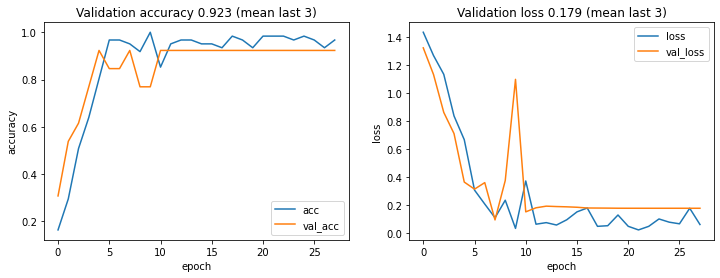

In [10]:
# Plots neural network performance metrics for train and validation
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Get the performance metrics
results = pd.DataFrame(history.history)

# Plot accuracy curves
results[["acc", "val_acc"]].plot(ax=ax1)
ax1.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(results["val_acc"][-3:]) # Last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")

# Plot loss curves
results[["loss", "val_loss"]].plot(ax=ax2)
ax2.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(results["val_loss"][-3:]) # Last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")

plt.show()

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

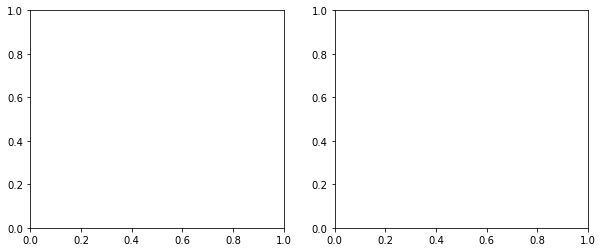

In [16]:
# Due to the use of a old version of python this code below will not work !

""" from sklearn.metrics import ConfusionMatrixDisplay

test_pred = model.predict(test_set)

# Compute the heigths probability for each entry
test_pred_labels = np.argmax(test_pred, axis=1)


# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, ax=ax0)
ax0.set_title("Confusion Matrix values")

ConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, normalize="true", ax=ax1)
ax1.set_title("Confusion Matrix percentage")
 """
plt.show()

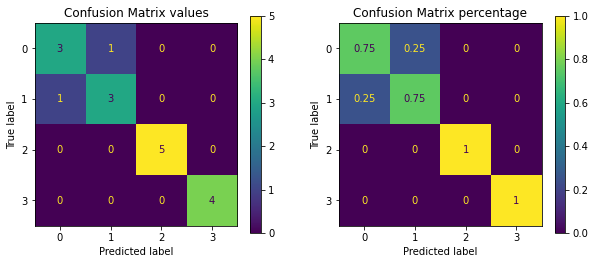

In [17]:
### Old vesion 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_pred = model.predict(test_set)

# Compute the heigths probability for each entry
test_pred_labels = np.argmax(test_pred, axis=1)

cm = confusion_matrix(test_set.labels, test_pred_labels)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

# Display Confusion Matrix
disp0 = ConfusionMatrixDisplay(confusion_matrix=cm)
disp0.plot(ax=ax0)
ax0.set_title("Confusion Matrix values")

# Display Normalized Confusion Matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp1.plot(ax=ax1)
ax1.set_title("Confusion Matrix percentage")

plt.show()


In [ ]:
np.round(test_pred * 100)

array([[ 59.,  41.,   0.,   0.],
       [100.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.],
       [  0., 100.,   0.,   0.],
       [ 24.,  76.,   0.,   0.],
       [  2.,  98.,   0.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.],
       [  0.,   0.,   0., 100.],
       [  0.,   0.,   0., 100.],
       [  0.,   0.,   0., 100.]], dtype=float32)

In [18]:
# Compute score on the test set
(test_loss, test_accuracy) = model.evaluate(test_set)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2%}".format(test_accuracy))

1/1 [==============================] - 1s 1s/step - loss: 0.1177 - acc: 0.8824
Test loss: 0.12
Test accuracy: 88.24%


In [ ]:
model.save("model.h5")

# To do check dataset and see if images are not good. try to have 100% accuray 

In [ ]:
filenames = os.listdir("dataset/row-data-test")
filenames

['Ciseaux Mayo', 'Ciseaux micro', 'Ciseaux Stevens', 'Ciseaux Stille']

In [ ]:
""" # Directory where the files are located
source_directory = "dataset/row-data-test"

# Loop through each filename
for filename in filenames:
    # Create a folder with the filename (without the extension)
    folder_name = os.path.splitext(filename)[0]
    folder_path = os.path.join(source_directory, folder_name)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Move the file to the folder
    source_file_path = os.path.join(source_directory, filename)
    destination_file_path = os.path.join(folder_path, filename)
    
    shutil.move(source_file_path, destination_file_path)

print("Files have been moved to their respective folders.") """

' # Directory where the files are located\nsource_directory = "dataset/row-data-test"\n\n# Loop through each filename\nfor filename in filenames:\n    # Create a folder with the filename (without the extension)\n    folder_name = os.path.splitext(filename)[0]\n    folder_path = os.path.join(source_directory, folder_name)\n    \n    if not os.path.exists(folder_path):\n        os.makedirs(folder_path)\n\n    # Move the file to the folder\n    source_file_path = os.path.join(source_directory, filename)\n    destination_file_path = os.path.join(folder_path, filename)\n    \n    shutil.move(source_file_path, destination_file_path)\n\nprint("Files have been moved to their respective folders.") '

In [ ]:
test = datagen.flow_from_directory(
                                    os.path.join("dataset", "row-data-test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=1,
                                    class_mode="sparse",
                                    )

Found 4 images belonging to 4 classes.


In [ ]:
# Compute score on the test set
(loss, accuracy) = model.evaluate(test)

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2%}".format(accuracy))

2/4 [==============>...............] - ETA: 0s - loss: 0.2696 - acc: 1.0000

4/4 [==============================] - 0s 92ms/step - loss: 0.1361 - acc: 1.0000
Test loss: 0.14
Test accuracy: 100.00%


In [ ]:
classes = {num: name for name, num in test.class_indices.items()}
classes

{0: 'Ciseaux Mayo',
 1: 'Ciseaux Stevens',
 2: 'Ciseaux Stille',
 3: 'Ciseaux micro'}

In [ ]:
predition = model.predict(test)
predition

4/4 [==============================] - 1s 128ms/step


array([[5.8492148e-01, 4.1501993e-01, 5.7403318e-05, 1.1686290e-06],
       [2.9385774e-03, 9.9703622e-01, 2.4237637e-05, 1.0096203e-06],
       [3.9625743e-06, 3.8791965e-03, 9.9609864e-01, 1.8162909e-05],
       [2.2852868e-09, 7.1527493e-06, 1.0470265e-03, 9.9894589e-01]],
      dtype=float32)

In [ ]:
for i in predition.argmax(axis=1):
    print(f"Image {i +1} is: {classes.get(i)}")

Image 1 is: Ciseaux Mayo
Image 2 is: Ciseaux Stevens
Image 3 is: Ciseaux Stille
Image 4 is: Ciseaux micro


## Save the model to json using tensorflowjs

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("model.h5")

model.summary()

AttributeError: module 'tensorflow' has no attribute 'keras'